In [7]:
from PosSelect_Functions_Old import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
import copy
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import wilcoxon
from scipy.optimize import curve_fit
from scipy.stats import fisher_exact

hfont = {'fontname':'Arial'}
plt.rcParams["font.family"] = "Arial"

#Code borrowed heavily from here: https://stackoverflow.com/questions/62375034/find-non-overlapping-area-between-two-kde-plots
plt.rcParams.update(
    {"text.usetex": False}
)

#Overwrite version that removes LCR etc. because we do not have comparable annotations for bats etc.
def read_noncoding_data_fast(path = "./", maf_cut = 0.25, spec_sup = 250, phylop_cut = -100, pc = -1, dist = 500000000):
    
    v = pd.read_csv(path + "HumChp_NC_Final_NoHLA_ReadFast.txt", sep = "\t")
    vv = pd.read_csv(path + "HumPoly_NC_Final_NoHLA_ReadFast.txt", sep = "\t")
    vv = vv.drop_duplicates("Position")
    v = v[~v["Position"].isin(list(vv["Position"]))]

    #Only keep if we have the essential columns for this analysis
    v = v.dropna(subset = ["SpecSup447", "PhyloP447", "Position", "NearestGene", "NearestDist"])
    vv = vv.dropna(subset = ["SpecSup447", "PhyloP447", "Position", "NearestGene", "NearestDist"])

    v["PhyloP447"] = v["PhyloP447"].astype(float)
    vv["PhyloP447"] = vv["PhyloP447"].astype(float)
    v["SpecSup447"] = v["SpecSup447"].astype(int)
    vv["SpecSup447"] = vv["SpecSup447"].astype(int)
    v["PhastCons447"] = v["PhastCons447"].astype(float)
    vv["PhastCons447"] = vv["PhastCons447"].astype(float)

    v = v[v['PhastCons447'].astype(float) > pc]
    vv = vv[vv['PhastCons447'].astype(float) > pc]

    print(v.shape)

    v = v[v['SpecSup447'].astype(int) > spec_sup]
    vv = vv[vv['SpecSup447'].astype(int) > spec_sup]

    print(v.shape)

    v = v[v['PhyloP447'].astype(float) >= phylop_cut]
    vv = vv[vv['PhyloP447'].astype(float) >= phylop_cut]

    v = v[v['NearestDist'].astype(float) <= dist]
    vv = vv[vv['NearestDist'].astype(float) <= dist]

    print(v.shape)

    yvalls = vv[vv["MAFMaxAcrossAncestry"] >= maf_cut]
    yvalls = yvalls[yvalls["MAFMaxAcrossAncestry"] <= 1-maf_cut]

    v.index = v["NearestGene"]
    yvalls.index = yvalls["NearestGene"]

    v = v.drop_duplicates("Position")
    yvalls = yvalls.drop_duplicates("Position")
        
    return v, yvalls

#Define a logarithmic function to fit to the data
def plot_stuff(df, title, xlabel, ylabel):
    def func(x, a, c, d):
        return a + d*np.log(x + c)

    #Fit said function
    popt, pcov = curve_fit(func, xdata=df["AF bin"], ydata=df["Alpha"], maxfev = 100000)
    sns.scatterplot(x=df["AF bin"], y=df["Alpha"])
    xx = np.linspace(0.1, 1, 100)
    yy = func(xx, *popt)
    plt.title(title, size = 18)
    plt.xlabel(xlabel, size = 15)
    plt.ylabel(ylabel, size = 15)
    plt.plot(xx, yy)



In [2]:
maf_cut = 0.1
spec_sup = 250

#Local version does not remove NewTEs or LCRs
v, yvalls = read_noncoding_data_fast(path = "./", maf_cut = maf_cut, spec_sup = spec_sup)
yvalls = add_unfold(yvalls)


(10748899, 6)
(5642872, 6)
(5642872, 6)


C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:583: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yvalls_alt["UnfoldedMAF"] = 1-yvalls_alt["MAFMaxAcrossAncestry"]
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:584: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yvalls_ref["UnfoldedMAF"] = yvalls_ref["MAFMaxAcrossAncestry"]


In [3]:
orthos = pd.read_csv("Alecto_Musculus_Homo_Orthos.txt", sep = ',')
orthos = orthos.dropna()
orthos = orthos[(orthos["Mouse homology type"] == "ortholog_one2one") & (orthos["Megabat homology type"] == "ortholog_one2one")]
orthos = orthos.drop_duplicates("Gene stable ID")

orth2 = pd.read_csv("Orthologs_HumMouseMarm.txt", sep = "\t")
orth2 = orth2[["Gene stable ID", "Gene name"]]
orthos = orthos.set_index("Gene stable ID").join(orth2.set_index("Gene stable ID"))

In [4]:
vu, yvallsu = read_utr(maf_cut = 0.1, spec_sup = 250)
yvallsu = unfold_utr(yvallsu)

v_use = pd.concat([v, vu])
vv_use = pd.concat([yvalls, yvallsu])

v_use = v_use[v_use["NearestGene"].isin(orthos["Gene name"])]
vv_use = vv_use[vv_use["NearestGene"].isin(orthos["Gene name"])]


C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:684: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  vv = pd.read_csv("HumPoly_UTR_Final.bed", sep = "\t")
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:692: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  p447 = pd.read_csv("447/HumChp_UTR_Final_NewPhyloP447.txt", sep = "\t").set_index("Position")
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:696: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  p447 = pd.read_csv("447/HumPoly_UTR_Final_NewPhyloP447.txt", sep = "\t").set_index("Position")


(163579, 10)
(162441, 10)
(162441, 10)
(162441, 10)
(120678, 10)


C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yvalls_alt["UnfoldedMAF"] = 1-yvalls_alt["MAFMaxAcrossAncestry"]
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:779: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yvalls_ref["UnfoldedMAF"] = yvalls_ref["MAFMaxAcrossAncestry"]


In [5]:
v_use = v_use[v_use["NearestGene"].isin(orthos["Gene name"])]
vv_use = vv_use[vv_use["NearestGene"].isin(orthos["Gene name"])]
vv_use

,Position,MAFMaxAcrossAncestry,NearestGene,NearestDist,PhyloP447,PhastCons447,SpecSup447,Human ref,Human alt,Chimp ref,Gorilla ref,UnfoldedMAF,Gene,MskHumPhyloP,MskHBCGOPhyloP,SpeciesSupport,470MammalPhastCons,3or5
chr1:623755-T-G,chr1:623755,0.302751,SAMD11,301981.0,-0.058,0.0,336,T,G,T,T,0.302751,NaN,NaN,NaN,NaN,NaN,NaN
chr1:624752-C-T,chr1:624752,0.383673,SAMD11,300984.0,0.038,0.0,344,C,T,C,C,0.383673,NaN,NaN,NaN,NaN,NaN,NaN
chr1:627736-G-C,chr1:627736,0.105304,SAMD11,298000.0,-0.720,0.0,298,G,C,G,G,0.105304,NaN,NaN,NaN,NaN,NaN,NaN
chr1:627983-C-T,chr1:627983,0.225779,SAMD11,297753.0,-0.110,0.0,375,C,T,C,C,0.225779,NaN,NaN,NaN,NaN,NaN,NaN
chr1:628778-C-T,chr1:628778,0.129787,SAMD11,296958.0,-0.226,0.0,345,C,T,C,C,0.129787,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:155053587-A-T,chrX:155053587,0.513391,MTCP1,17599.0,0.236,0.001,311,A,T,T,T,0.486609,NaN,NaN,NaN,NaN,NaN,NaN
chrX:155211883-T-C,chrX:155211883,0.610736,VBP1,4562.0,1.814,0.0,278,T,C,C,C,0.389264,NaN,NaN,NaN,NaN,NaN,NaN
chrX:155223101-C-G,chrX:155223101,0.539902,VBP1,6656.0,-0.151,0.0,284,C,G,G,G,0.460098,NaN,NaN,NaN,NaN,NaN,NaN
chrX:155256667-G-A,chrX:155256667,0.766725,RAB39B,7830.0,-0.135,0.0,391,G,A,A,A,0.233275,NaN,NaN,NaN,NaN,NaN,NaN


C:\Users\astar\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.008090747077917959


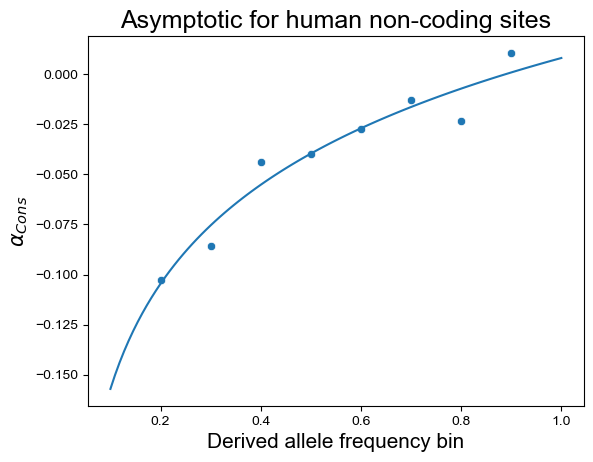

In [8]:
alpha, to_plot = asymptotic_unfold_cutoff(v_use, vv_use, start = 0.1, dn_cut = 0.0001, to_plot_curve = False, cuttt = 0.95)
plot_stuff(to_plot, title = "Asymptotic for human non-coding sites", ylabel = "$\\alpha_{Cons}$", xlabel = "Derived allele frequency bin")
print(alpha)

(0.022395890445295663,
    AF bin     Alpha  Cutoff              [[dc1, du1], [pc1, pu1]]  \
 0     0.2 -0.060942   0.850  [[571885, 2427193], [96785, 387193]]   
 1     0.3 -0.053253   0.845  [[574947, 2424131], [55970, 224021]]   
 2     0.4 -0.034336   0.831  [[583630, 2415448], [40493, 162010]]   
 3     0.5 -0.030237   0.828  [[585583, 2413495], [31936, 127778]]   
 4     0.6 -0.032218   0.830  [[584246, 2414832], [25293, 101278]]   
 5     0.7 -0.009234   0.813   [[594857, 2404221], [21494, 86092]]   
 6     0.8 -0.005456   0.810   [[596697, 2402381], [18427, 73796]]   
 7     0.9  0.022081   0.789   [[610200, 2388878], [17775, 71159]]   
 
                [[dc2, du2], [pc2, pu2]]  Num Poly in Bin  
 0  [[572486, 2426592], [96891, 387087]]           483978  
 1  [[575547, 2423531], [56015, 223976]]           279991  
 2  [[584246, 2414832], [40530, 161973]]           202503  
 3  [[586220, 2412858], [31977, 127737]]           159714  
 4  [[584884, 2414194], [25320, 101251]]     

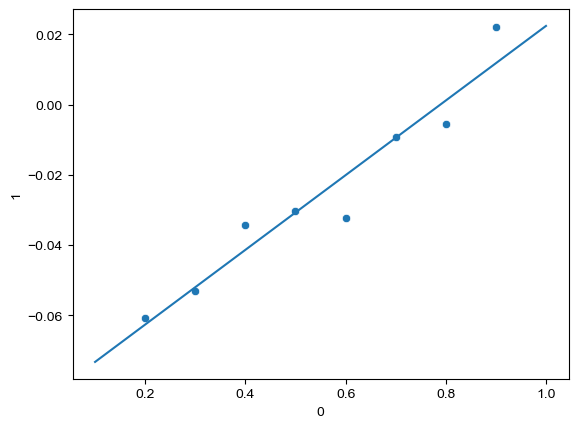

In [11]:
v_use = v_use[v_use["SpecSup447"] > 350]
vv_use = vv_use[vv_use["SpecSup447"] > 350]

asymptotic_unfold_cutoff(v_use, vv_use, start = 0.1, dn_cut = 0.0001, to_plot_curve = True, cuttt = 0.8)

In [12]:
hpo = pd.read_csv("../DPSC_CNCC/HPO_AccelEvol_Input.txt", sep= "\t")
d_HPO = {}

for index, row in hpo.iterrows():
    d_HPO[row["Term"]] = row["Genes"].split(";")

In [69]:
vk = v[v["NearestGene"].isin(d_HPO["Moderate global developmental delay"])]
vvk = yvalls[yvalls["NearestGene"].isin(d_HPO["Moderate global developmental delay"])]
vvk = vvk[(vvk["MAFMaxAcrossAncestry"] > 0.25) & (vvk["MAFMaxAcrossAncestry"] < 0.75)]
from collections import Counter

In [70]:
from collections import Counter
Counter(vk["NearestGene"])

Counter({'SDHB': 109,
         'PHGDH': 121,
         'CNNM2': 224,
         'HAL': 152,
         'TPP2': 844,
         'IRX5': 1684,
         'TBX4': 239,
         'SDHAF1': 14,
         'ADNP': 125,
         'EGF': 374,
         'SDHA': 34,
         'PGM3': 299,
         'TMEM70': 7,
         'AIFM1': 35})

In [68]:
x = pd.read_csv("Finalizing_HPO_FilterNewTEs_FisherExact_NonCod_PhyloP447_MAFCut0.25_SpecSup250_PhyloPCut-100_PhastConsCut-1.csv")
x = x[x["Proportion"] == 0.8]
x["FDR MWU"] = fdrcorrection(x["MWU p-value; alt greater"])[1]
x["FDR FE"] = fdrcorrection(x["Fisher exact p-value; alt greater"])[1]
x.sort_values("FDR MWU").head(50)

,Term,Median Fixed PhyloP,Number Fixed Variants,Median Polymorphic PhyloP,Number Polymorphic Variants,Fisher exact p-value,MWU p-value,Fisher exact p-value; alt greater,MWU p-value; alt greater,alpha,Cutoff,"[[dc1, du1], [pc1, pu1]]","[[dc2, du2], [pc2, pu2]]",Proportion,FDR MWU,FDR FE
71,Open mouth,0.0220,41915,-0.0040,8907,0.002476,0.000032,0.001260,0.000016,0.083949,0.732,"[[8984, 32931], [1781, 7126]]","[[8995, 32920], [1783, 7124]]",0.8,0.018808,0.238816
123,"Intellectual disability, progressive",0.0500,14467,0.0050,3322,0.005002,0.000046,0.002602,0.000023,0.125049,0.743,"[[3215, 11252], [664, 2658]]","[[3216, 11251], [665, 2657]]",0.8,0.018808,0.256897
1,Increased circulating total IgE level,0.0830,4152,-0.0070,798,0.000023,0.000109,0.000011,0.000055,0.327858,0.608,"[[1125, 3027], [159, 639]]","[[1125, 3027], [160, 638]]",0.8,0.022621,0.018597
170,Hyperkinetic movements,0.0160,9869,-0.0470,2344,0.008530,0.000114,0.004326,0.000057,0.139563,0.638,"[[2220, 7649], [467, 1877]]","[[2221, 7648], [470, 1874]]",0.8,0.022621,0.338635
6,Flushing,0.0580,4180,-0.0055,1152,0.000188,0.000138,0.000103,0.000069,0.260485,0.587,"[[1055, 3125], [230, 922]]","[[1058, 3122], [231, 921]]",0.8,0.022621,0.084507
1042,Abnormally large globe,0.0450,7622,-0.0170,1786,0.087149,0.000270,0.043150,0.000135,0.107362,0.771,"[[1668, 5954], [357, 1429]]","[[1670, 5952], [358, 1428]]",0.8,0.036939,0.999127
151,Moderate global developmental delay,-0.0235,4154,-0.0895,1164,0.006884,0.000657,0.003717,0.000329,0.197515,0.588,"[[985, 3169], [232, 932]]","[[986, 3168], [233, 931]]",0.8,0.077205,0.305509
93,Abnormality of the hip bone,-0.0560,17547,-0.0840,4661,0.003335,0.001174,0.001669,0.000587,0.113185,0.588,"[[3855, 13692], [931, 3730]]","[[3861, 13686], [933, 3728]]",0.8,0.120642,0.238816
511,Ureterocele,0.1260,7661,0.0620,2179,0.036291,0.001683,0.018675,0.000842,0.118815,0.895,"[[1691, 5970], [435, 1744]]","[[1693, 5968], [436, 1743]]",0.8,0.131446,0.624119
1369,Clumsiness,0.0090,12317,-0.0250,2982,0.120932,0.001783,0.061173,0.000892,0.076462,0.674,"[[2626, 9691], [596, 2386]]","[[2627, 9690], [598, 2384]]",0.8,0.131446,1.000000


In [73]:
vvk.sort_values("PhyloP447")

,Position,MAFMaxAcrossAncestry,NearestGene,NearestDist,PhyloP447,PhastCons447,SpecSup447,Human ref,Human alt,Chimp ref,Gorilla ref,UnfoldedMAF,FixedOrPoly
chr1:17075760-C-T,chr1:17075760,0.666763,SDHB,21689,-20.000,0.0,443,C,T,C,C,0.666763,Polymorphic
chr13:102596871-A-G,chr13:102596871,0.720747,TPP2,0,-20.000,0.0,403,A,G,A,A,0.720747,Polymorphic
chr1:17086626-A-C,chr1:17086626,0.579837,SDHB,32555,-12.192,0.0,442,A,C,A,A,0.579837,Polymorphic
chr5:219446-A-G,chr5:219446,0.324879,SDHA,1110,-10.059,0.0,370,A,G,A,A,0.324879,Polymorphic
chr16:54984712-G-A,chr16:54984712,0.685293,IRX5,53789,-8.660,0.0,404,G,A,G,G,0.685293,Polymorphic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr16:54891670-C-G,chr16:54891670,0.603567,IRX5,39253,5.926,1.0,443,C,G,G,G,0.396433,Polymorphic
chr16:54779607-G-A,chr16:54779607,0.320898,IRX5,151316,5.934,1.0,445,G,A,G,G,0.320898,Polymorphic
chr16:54999782-T-C,chr16:54999782,0.533359,IRX5,68859,6.378,1.0,420,T,C,C,C,0.466641,Polymorphic
chr16:54743059-G-A,chr16:54743059,0.285852,IRX5,187864,8.408,1.0,444,G,A,G,G,0.285852,Polymorphic


C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed["FixedOrPoly"] = x
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed["MAFMaxAcrossAncestry"] = z
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

(-0.0480180454176804, 1.5, [[360, 3901], [106, 1096]], [[360, 3901], [106, 1096]], <Figure size 1000x600 with 1 Axes>)


MannwhitneyuResult(statistic=2720470.5, pvalue=0.0009494223738415219)

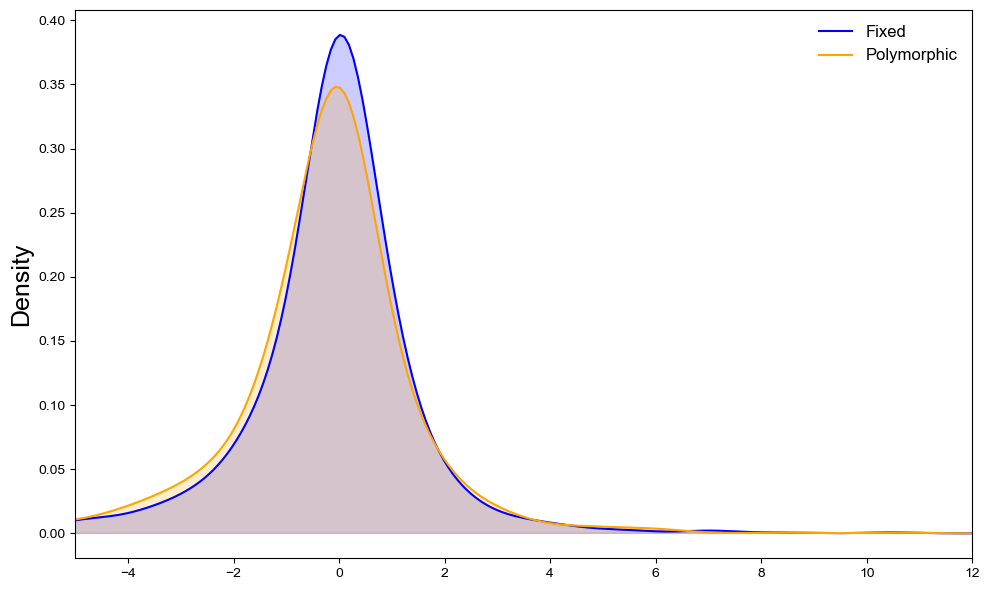

In [71]:
vvv = prepare_alpha(vk, vvk)
print(compute_alpha_cutoff(vvv, plot = True, cutoff = 1.5))
mwu(vk["PhyloP447"], vvk["PhyloP447"])

C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poly["FixedOrPoly"] = y
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed["FixedOrPoly"] = x
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

(0.14177489177489178, 1.5, [[198, 2379], [52, 728]], [[198, 2379], [52, 728]], <Figure size 1000x600 with 1 Axes>)


MannwhitneyuResult(statistic=2720470.5, pvalue=0.0009494223738415219)

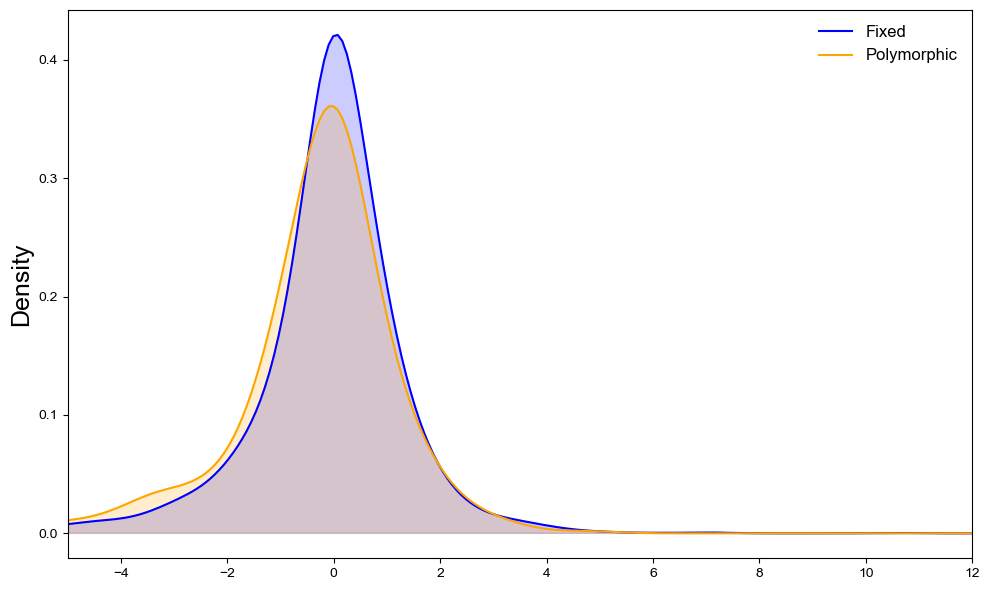

In [74]:
vvv = prepare_alpha(vk[~vk["NearestGene"].isin(["IRX5"])], vvk[~vvk["NearestGene"].isin(["IRX5"])])
print(compute_alpha_cutoff(vvv, plot = True, cutoff = 1.5))
mwu(vk["PhyloP447"], vvk["PhyloP447"])

In [17]:
fisher_exact([[1358, 2886], [537, 1348]])

SignificanceResult(statistic=1.1811880638696282, pvalue=0.006418182487408754)

C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poly["FixedOrPoly"] = y
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed["FixedOrPoly"] = x
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

(0.5617715617715617,
 1.0047114228456913,
 [1.0047114228456913, 4.316800000000001],
 'dc > 0.1, likely stable',
 [[13, 94], [2, 33]],
 <Figure size 1000x600 with 1 Axes>)

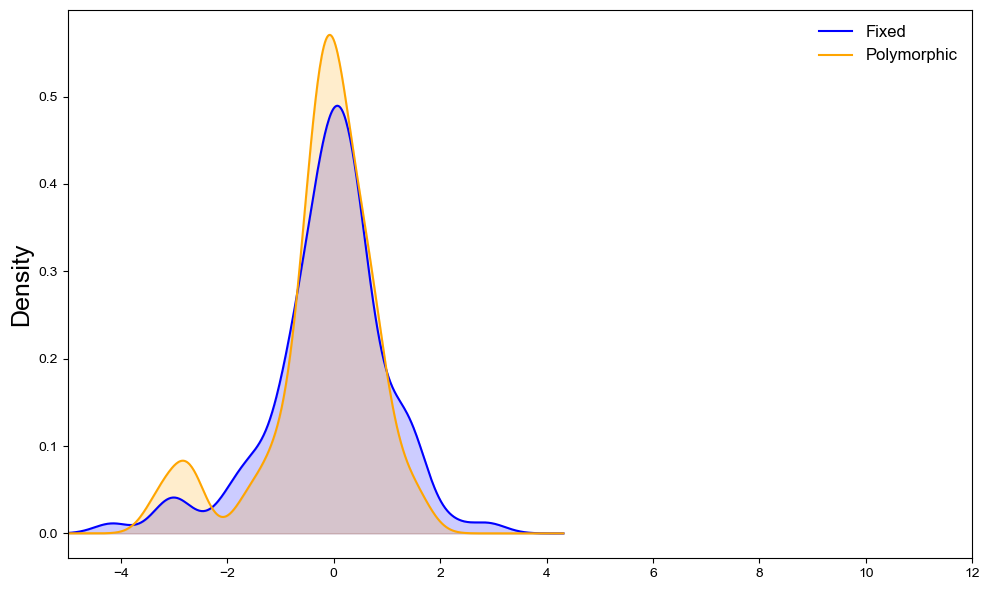

In [19]:
vvv = prepare_alpha(vk[vk["NearestGene"].isin(["PLA2G7"])], vvk[vvk["NearestGene"].isin(["PLA2G7"])])
compute_alpha_new(vvv, plot = True)

In [22]:
vk[vk["NearestGene"].isin(["PLA2G7"])].sort_values("NearestDist").head(50)

,Position,NearestGene,NearestDist,PhyloP447,PhastCons447,SpecSup447,FixedOrPoly,MAFMaxAcrossAncestry,UnfoldedMAF
NearestGene,,,,,,,,,
PLA2G7,chr6:46735390,PLA2G7,0,0.387,0.000,348,Fixed,.,.
PLA2G7,chr6:46735469,PLA2G7,0,-1.952,0.000,382,Fixed,.,.
PLA2G7,chr6:46735501,PLA2G7,0,-2.746,0.000,388,Fixed,.,.
PLA2G7,chr6:46735540,PLA2G7,0,-0.194,0.000,328,Fixed,.,.
PLA2G7,chr6:46735949,PLA2G7,0,0.950,0.000,338,Fixed,.,.
PLA2G7,chr6:46736003,PLA2G7,0,0.085,0.000,413,Fixed,.,.
PLA2G7,chr6:46736340,PLA2G7,0,-0.199,0.000,387,Fixed,.,.
PLA2G7,chr6:46735422,PLA2G7,0,1.227,0.000,335,Fixed,.,.
PLA2G7,chr6:46736698,PLA2G7,1336,-0.063,0.000,349,Fixed,.,.
